# Linear fit with constraint
Author: Aleksander Filip Żarnecki (University of Warsaw)

### (0) Import libraries 

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import f

### (1) Definition of model

Consider controlled parameter range is [-1,1]

In [2]:
# True functional dependece: sin(x)

def mytrue(x):
    
    val = 0.5 + 0.5*np.cos(x*np.pi + 0.5*np.cos(x*np.pi/2.))

    return val

# Basic functions:  1, x, x^2, x^3 ...

def myfun(x,ifun):

    return np.power(x,ifun)

# Full polynomial model

def mymodel(x,par):

    val = np.zeros(x.size)
    
    for ip in range(par.size):
        val+=par[ip]*myfun(x,ip)
        
    return val


### (2) Generate pseudo data to fit

In [3]:
# Considered values of x

xvec = np.linspace(-0.95,0.95,20)

# Measurement precision (high)

svec = np.linspace(0.02,0.03,xvec.size)
s2vec = svec*svec

# Pseudo-data

yvec = np.random.normal(mytrue(xvec),svec)


### (3)  Linear fit without constraint

In [4]:
# Number of model functions to consider 

Nfun = 4

A = np.zeros((Nfun,Nfun))

B = np.zeros(Nfun)

for l in range(Nfun):
    fl = myfun(xvec,l)
    B[l] = np.sum(fl*yvec/s2vec)
    for k in range(Nfun):
        fk = myfun(xvec,k)
        A[l,k] = np.sum(fl*fk/s2vec)


# Inverse of matrix

Cov = np.linalg.inv(A)

# Solution to the problem

par = Cov @ B

# Parameter uncertainties

epar = np.sqrt(np.diagonal(Cov))

print("\n Fit results:\n\n     par         sigma_p\n")

for ip in range(par.size):
    print("  %8.3f  +/- %6.3f " % (par[ip],epar[ip]))

# Calculate correlation matrix, including rounding

Corr = Cov

print("\n Correlation matrix\n")
for ip in range(par.size):
    for jp in range(par.size):
        Corr[ip,jp]=int(1000.*Corr[ip,jp]/epar[ip]/epar[jp]+0.5)/1000.
        
    print(Corr[ip,:])

# Fitted function

fvec = mymodel(xvec,par) 

# Chi^2 printout

chi2 = np.sum((yvec-fvec)**2/s2vec)

print("\n chi^2 =  %8.3f   chi^2/Ndf = %8.5f " % (chi2,chi2/(xvec.size-Nfun)))

# print("\n  x       y         f(x) ")
# for ix in range(xvec.size):
#     print("%6.3f  %8.5f  %8.5f " % (xvec[ix],yvec[ix],fvec[ix]))


 Fit results:

     par         sigma_p

     0.842  +/-  0.008 
    -0.422  +/-  0.024 
    -1.079  +/-  0.019 
     0.486  +/-  0.037 

 Correlation matrix

[ 1.     0.144 -0.743 -0.156]
[ 0.144  1.    -0.105 -0.913]
[-0.743 -0.105  1.     0.209]
[-0.156 -0.913  0.209  1.   ]

 chi^2 =   318.876   chi^2/Ndf = 19.92973 


### (4)  Linear fit with constraint (Lagrange method)

In [5]:
# Number of constraints

Ncon = 2

# Constraints given in matrix form    D @ par = E

D = np.zeros((Ncon,Nfun))
E = np.zeros(Ncon)

# First constraint: value at 1 is 0

for l in range(Nfun):
    D[0,l]=1.0

E[0] = 0.0
    
# Second constraint: value at -1 is 0

for l in range(Nfun):
    D[1,l]=np.power(-1.0,l)

E[1] = 0.0


In [6]:
# Work arrays for new fit

Ac = np.zeros((Nfun+Ncon,Nfun+Ncon))

Bc = np.zeros(Nfun+Ncon)

for l in range(Nfun):
    fl = myfun(xvec,l)
    Bc[l] = np.sum(fl*yvec/s2vec)
    for k in range(Nfun):
        fk = myfun(xvec,k)
        Ac[l,k] = np.sum(fl*fk/s2vec)

# Add constraints

    for k in range(Nfun,Nfun+Ncon):
        Ac[k,l] = D[k-Nfun,l]
        Ac[l,k] = D[k-Nfun,l]

for l in range(Nfun,Nfun+Ncon):
    Bc[l]=E[l-Nfun]


In [7]:
# Inverse of matrix

CCov = np.linalg.inv(Ac)

# Solution to the problem

parc = CCov @ Bc

# Parameter uncertainties
# consider covariance matrix for parameters only

Cpar = CCov[:Nfun,:Nfun]

eparc = np.sqrt(np.diagonal(Cpar))

print("\n Fit results:\n\n     par         sigma_p\n")

for ip in range(Nfun):
    print("  %8.3f  +/- %6.3f " % (parc[ip],eparc[ip]))

# Fitted function

fcvec = mymodel(xvec,parc[:Nfun]) 

# Chi^2 printout

chi2c = np.sum((yvec-fcvec)**2/s2vec)

print("\n chi^2 =  %8.3f   chi^2/Ndf = %8.5f " % (chi2c,chi2c/(xvec.size-Nfun+Ncon)))

# print("\n  x       y         f(x) ")
# for ix in range(xvec.size):
#     print("%6.3f  %8.5f  %8.5f " % (xvec[ix],yvec[ix],fcvec[ix]))


 Fit results:

     par         sigma_p

     0.783  +/-  0.008 
    -0.319  +/-  0.020 
    -0.783  +/-  0.008 
     0.319  +/-  0.020 

 chi^2 =   694.028   chi^2/Ndf = 38.55713 


In [8]:

dchi = chi2c - chi2

Fc = (dchi/Ncon)/(chi2/(xvec.size-Nfun))

print("\n F statistics for constraint: %.3f " % (Fc))

pc = f.sf(Fc,Ncon,xvec.size-Nfun)

print("\n Statistical fluctuation probability p = %.3g" % (pc))



 F statistics for constraint: 9.412 

 Statistical fluctuation probability p = 0.00199


### (5)  Linear fit with constraints (reduced model)

In [9]:
# Number of constraints

Ncon = 2

# Number of parameters in "reduced function" 

Nred = Nfun-Ncon

# reduced model
# Constrains included in the functions formula
# For given number of input parameters, additional terms added to
# take constraints into account (one for even and one for odd terms)

def myred(x,par):

    parsum = np.zeros(2)
    
    for ip in range(par.size):
        parsum[ip%2] -= par[ip]
        
    npar = np.zeros(par.size+2)

    npar[:par.size]=par
    npar[par.size] = parsum[par.size%2]
    npar[par.size+1] = parsum[(par.size+1)%2]
    
    val = np.zeros(x.size)
    
    for ip in range(npar.size):
        val+=npar[ip]*myfun(x,ip)
        
    return val


Ar = np.zeros((Nred,Nred))

Br = np.zeros(Nred)

# additional terms for even and odd powers

lc = np.empty(2, dtype=int)

if Nred%2 == 0 :
    lc[0] = Nred
    lc[1] = Nred+1
else:    
    lc[0] = Nred+1
    lc[1] = Nred

# Calculate arrays including constrain terms

for l in range(Nred):
    fl = myfun(xvec,l) - myfun(xvec,lc[l%2])
    Br[l] = np.sum(fl*yvec/s2vec)
    for k in range(Nred):
        fk = myfun(xvec,k) - myfun(xvec,lc[k%2])
        Ar[l,k] = np.sum(fl*fk/s2vec)


# Inverse of matrix

RCov = np.linalg.inv(Ar)

# Solution to the problem

parr = RCov @ Br

# Parameter uncertainties

eparr = np.sqrt(np.diagonal(RCov))

print("\n Fit results:\n\n     par         sigma_p\n")

for ip in range(parr.size):
    print("  %8.3f  +/- %6.3f " % (parr[ip],eparr[ip]))

# Calculate correlation matrix, including rounding

RCorr = RCov

print("\n Correlation matrix\n")
for ip in range(parr.size):
    for jp in range(parr.size):
        RCorr[ip,jp]=int(1000.*RCorr[ip,jp]/eparr[ip]/eparr[jp]+0.5)/1000.
        
    print(RCorr[ip,:])

# Fitted function

frvec = myred(xvec,parr) 

# Chi^2 printout

chi2r = np.sum((yvec-frvec)**2/s2vec)

print("\n chi^2 =  %8.3f   chi^2/Ndf = %8.5f " % (chi2r,chi2r/(xvec.size-Nred)))

# print("\n  x       y         f(x) ")
# for ix in range(xvec.size):
#     print("%6.3f  %8.5f  %8.5f " % (xvec[ix],yvec[ix],fvec[ix]))


 Fit results:

     par         sigma_p

     0.783  +/-  0.008 
    -0.319  +/-  0.020 

 Correlation matrix

[1.    0.159]
[0.159 1.   ]

 chi^2 =   694.028   chi^2/Ndf = 38.55713 


In [10]:

dchi = chi2r - chi2

Fr = (dchi/Ncon)/(chi2/(xvec.size-Nfun))

print("\n F statistics for constraint: %.3f " % (Fr))

pr = f.sf(Fr,Ncon,xvec.size-Nfun)

print("\n Statistical fluctuation probability p = %.3g" % (pr))



 F statistics for constraint: 9.412 

 Statistical fluctuation probability p = 0.00199


### (6) Draw data and all fit results

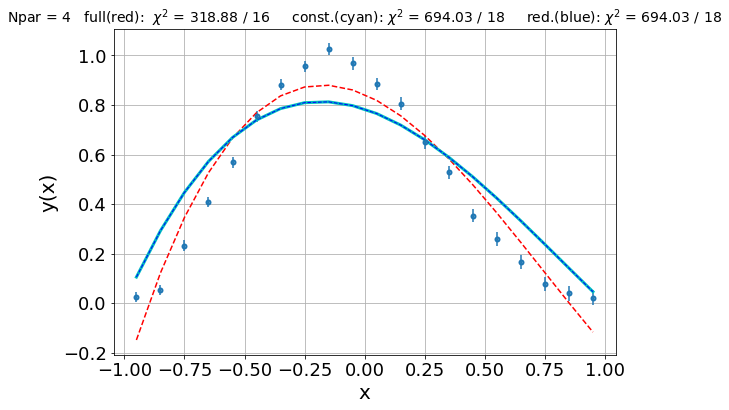

In [11]:
plt.figure(figsize=(9, 6))

plt.errorbar(xvec,yvec,svec, linestyle='none', marker='o', ms=2, mew=4)

plt.plot(xvec,fvec,'r--')
plt.plot(xvec,fcvec,'c-',linewidth=3)
plt.plot(xvec,frvec,'b--',linewidth=1)

plt.title('Npar = '+str(Nfun)+'   full(red):  $\chi^{2}$ = '+str(int(100*chi2+0.5)/100.)+' / '+str(xvec.size-Nfun)
                +'     const.(cyan): $\chi^{2}$ = '+str(int(100*chi2c+0.5)/100.)+' / '+str(xvec.size-Nfun+Ncon)
                +'     red.(blue): $\chi^{2}$ = '+str(int(100*chi2r+0.5)/100.)+' / '+str(xvec.size-Nfun+Ncon)   ,size=14)
    
plt.xlabel('x',size=20)
plt.ylabel('y(x)',size=20)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(which='major', axis='both')

fname = '09_const2_'+str(Nfun)+'.png'
plt.savefig(fname)